In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.visualization import cycle_plot, save_plot
from src.data import LoadData, list_dataset, get_json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets

In [2]:
featurenames = get_json('references/col_to_feat.json')
train = LoadData('train_FD001.txt', sep='\s+', names=featurenames)
train.features[:5]

array([[ 1.00000e+00,  1.00000e+00, -7.00000e-04, -4.00000e-04,
         1.00000e+02,  5.18670e+02,  6.41820e+02,  1.58970e+03,
         1.40060e+03,  1.46200e+01,  2.16100e+01,  5.54360e+02,
         2.38806e+03,  9.04619e+03,  1.30000e+00,  4.74700e+01,
         5.21660e+02,  2.38802e+03,  8.13862e+03,  8.41950e+00,
         3.00000e-02,  3.92000e+02,  2.38800e+03,  1.00000e+02,
         3.90600e+01,  2.34190e+01],
       [ 1.00000e+00,  2.00000e+00,  1.90000e-03, -3.00000e-04,
         1.00000e+02,  5.18670e+02,  6.42150e+02,  1.59182e+03,
         1.40314e+03,  1.46200e+01,  2.16100e+01,  5.53750e+02,
         2.38804e+03,  9.04407e+03,  1.30000e+00,  4.74900e+01,
         5.22280e+02,  2.38807e+03,  8.13149e+03,  8.43180e+00,
         3.00000e-02,  3.92000e+02,  2.38800e+03,  1.00000e+02,
         3.90000e+01,  2.34236e+01],
       [ 1.00000e+00,  3.00000e+00, -4.30000e-03,  3.00000e-04,
         1.00000e+02,  5.18670e+02,  6.42350e+02,  1.58799e+03,
         1.40420e+03,  1.46200

In [3]:
scaled_train, scaler = train.standardize()

In [4]:
class NN(nn.Module):
    """Neural Network Generator."""
    def __init__(self, input_size=24, hidden_sizes=[20,15], output_size=1, drop_p=0.4):
        """Generate fully-connected neural network.

        parameters
        ----------
        input_size (int): size of the input
        hidden_sizes (list of int): size of the hidden layers
        output_layer (int): size of the output layer
        drop_p (float): dropout probability
        """
        super().__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_sizes[0])
        ])
        layers = zip(hidden_sizes[:-1], hidden_sizes[1:])
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in layers])
        self.output = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(drop_p)
    
    def forward(self, X):
        for index, linear in enumerate(self.hidden_layers):
            if index % 2 == 0:
                X = linear(X)
                X = self.dropout(X)
            elif index % 2 != 0:
                X = torch.tanh(linear(X))
        
        X = self.output(X)

        return F.relu(X)
#         return X

In [5]:
def training(
    model,
    criterion,
    optimizer,
    featureloader,
    labelloader,
    epochs=5,
    print_every=40
):
    epoch_loss = 0
    steps = 0
    1
    for epoch in range(epochs):
        for features, labels in zip(featureloader, labelloader):
            steps += 1
            features, labels = features.type(torch.FloatTensor), labels.type(torch.FloatTensor)
            labels.resize_(labels.shape[0], 1)
            
            output = model.forward(features)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if steps % print_every == 0:
                print('Epoch: {}/{}..'.format(epoch+1, epochs),
                      'Training loss: {:.3f}'.format(epoch_loss/print_every))

                epoch_loss = 0

In [8]:
featureset = torch.from_numpy(scaled_train[:,2:])
labelset = torch.from_numpy(train.target)

featureloader = torch.utils.data.DataLoader(featureset, batch_size=32)
labelloader = torch.utils.data.DataLoader(labelset, batch_size=32)

In [49]:
model = NN(hidden_sizes=[30, 15])

optimizer = optim.RMSprop(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

training(model, criterion, optimizer, featureloader, labelloader, epochs=150, print_every=60)

Epoch: 1/150.. Training loss: 15531.182
Epoch: 1/150.. Training loss: 12517.763
Epoch: 1/150.. Training loss: 8934.156
Epoch: 1/150.. Training loss: 8416.421
Epoch: 1/150.. Training loss: 10267.745
Epoch: 1/150.. Training loss: 9529.734
Epoch: 1/150.. Training loss: 10970.965
Epoch: 1/150.. Training loss: 11785.343
Epoch: 1/150.. Training loss: 10046.226
Epoch: 1/150.. Training loss: 10937.389
Epoch: 2/150.. Training loss: 10990.589
Epoch: 2/150.. Training loss: 7333.386
Epoch: 2/150.. Training loss: 5868.357
Epoch: 2/150.. Training loss: 4328.906
Epoch: 2/150.. Training loss: 3697.618
Epoch: 2/150.. Training loss: 5199.400
Epoch: 2/150.. Training loss: 5354.514
Epoch: 2/150.. Training loss: 9662.640
Epoch: 2/150.. Training loss: 3717.498
Epoch: 2/150.. Training loss: 6203.951
Epoch: 2/150.. Training loss: 9046.713
Epoch: 3/150.. Training loss: 4285.361
Epoch: 3/150.. Training loss: 2885.899
Epoch: 3/150.. Training loss: 3267.372
Epoch: 3/150.. Training loss: 2388.896
Epoch: 3/150.. Tr

Epoch: 20/150.. Training loss: 2303.453
Epoch: 20/150.. Training loss: 3430.868
Epoch: 20/150.. Training loss: 1410.082
Epoch: 20/150.. Training loss: 2956.633
Epoch: 20/150.. Training loss: 2254.077
Epoch: 21/150.. Training loss: 1426.261
Epoch: 21/150.. Training loss: 1222.212
Epoch: 21/150.. Training loss: 1110.459
Epoch: 21/150.. Training loss: 1086.684
Epoch: 21/150.. Training loss: 1022.481
Epoch: 21/150.. Training loss: 1553.831
Epoch: 21/150.. Training loss: 2688.191
Epoch: 21/150.. Training loss: 2662.355
Epoch: 21/150.. Training loss: 1788.234
Epoch: 21/150.. Training loss: 2820.229
Epoch: 22/150.. Training loss: 2315.658
Epoch: 22/150.. Training loss: 1034.271
Epoch: 22/150.. Training loss: 1319.971
Epoch: 22/150.. Training loss: 1190.979
Epoch: 22/150.. Training loss: 841.845
Epoch: 22/150.. Training loss: 926.436
Epoch: 22/150.. Training loss: 1671.119
Epoch: 22/150.. Training loss: 4139.507
Epoch: 22/150.. Training loss: 1279.267
Epoch: 22/150.. Training loss: 2001.446
Ep

Epoch: 39/150.. Training loss: 1905.247
Epoch: 39/150.. Training loss: 3220.176
Epoch: 40/150.. Training loss: 1619.721
Epoch: 40/150.. Training loss: 1274.412
Epoch: 40/150.. Training loss: 1051.775
Epoch: 40/150.. Training loss: 1080.373
Epoch: 40/150.. Training loss: 1066.366
Epoch: 40/150.. Training loss: 1045.725
Epoch: 40/150.. Training loss: 2309.104
Epoch: 40/150.. Training loss: 3548.723
Epoch: 40/150.. Training loss: 1378.170
Epoch: 40/150.. Training loss: 2916.951
Epoch: 40/150.. Training loss: 2211.051
Epoch: 41/150.. Training loss: 1353.567
Epoch: 41/150.. Training loss: 1209.752
Epoch: 41/150.. Training loss: 1100.046
Epoch: 41/150.. Training loss: 1072.185
Epoch: 41/150.. Training loss: 949.391
Epoch: 41/150.. Training loss: 1582.376
Epoch: 41/150.. Training loss: 2779.319
Epoch: 41/150.. Training loss: 2550.607
Epoch: 41/150.. Training loss: 1758.841
Epoch: 41/150.. Training loss: 2737.826
Epoch: 42/150.. Training loss: 2289.548
Epoch: 42/150.. Training loss: 1007.101
E

Epoch: 59/150.. Training loss: 910.552
Epoch: 59/150.. Training loss: 830.039
Epoch: 59/150.. Training loss: 1807.681
Epoch: 59/150.. Training loss: 4156.527
Epoch: 59/150.. Training loss: 1319.995
Epoch: 59/150.. Training loss: 1874.428
Epoch: 59/150.. Training loss: 3426.690
Epoch: 60/150.. Training loss: 1503.995
Epoch: 60/150.. Training loss: 1198.726
Epoch: 60/150.. Training loss: 1026.531
Epoch: 60/150.. Training loss: 1045.217
Epoch: 60/150.. Training loss: 1084.536
Epoch: 60/150.. Training loss: 1079.986
Epoch: 60/150.. Training loss: 2255.477
Epoch: 60/150.. Training loss: 3436.178
Epoch: 60/150.. Training loss: 1361.006
Epoch: 60/150.. Training loss: 2907.835
Epoch: 60/150.. Training loss: 2318.873
Epoch: 61/150.. Training loss: 1280.724
Epoch: 61/150.. Training loss: 1187.730
Epoch: 61/150.. Training loss: 1166.860
Epoch: 61/150.. Training loss: 1093.734
Epoch: 61/150.. Training loss: 940.063
Epoch: 61/150.. Training loss: 1496.820
Epoch: 61/150.. Training loss: 2680.625
Epo

Epoch: 78/150.. Training loss: 1183.250
Epoch: 78/150.. Training loss: 1975.461
Epoch: 78/150.. Training loss: 3387.584
Epoch: 79/150.. Training loss: 1556.070
Epoch: 79/150.. Training loss: 832.085
Epoch: 79/150.. Training loss: 1399.469
Epoch: 79/150.. Training loss: 1280.519
Epoch: 79/150.. Training loss: 898.548
Epoch: 79/150.. Training loss: 805.462
Epoch: 79/150.. Training loss: 1837.702
Epoch: 79/150.. Training loss: 4003.835
Epoch: 79/150.. Training loss: 1390.606
Epoch: 79/150.. Training loss: 1858.004
Epoch: 79/150.. Training loss: 3426.615
Epoch: 80/150.. Training loss: 1501.271
Epoch: 80/150.. Training loss: 1217.342
Epoch: 80/150.. Training loss: 1005.207
Epoch: 80/150.. Training loss: 1099.895
Epoch: 80/150.. Training loss: 1063.741
Epoch: 80/150.. Training loss: 1074.366
Epoch: 80/150.. Training loss: 2250.571
Epoch: 80/150.. Training loss: 3574.721
Epoch: 80/150.. Training loss: 1363.828
Epoch: 80/150.. Training loss: 2908.978
Epoch: 80/150.. Training loss: 2286.684
Epo

Epoch: 98/150.. Training loss: 1231.547
Epoch: 98/150.. Training loss: 864.198
Epoch: 98/150.. Training loss: 911.133
Epoch: 98/150.. Training loss: 1665.216
Epoch: 98/150.. Training loss: 4432.884
Epoch: 98/150.. Training loss: 1239.943
Epoch: 98/150.. Training loss: 1961.975
Epoch: 98/150.. Training loss: 3403.016
Epoch: 99/150.. Training loss: 1557.008
Epoch: 99/150.. Training loss: 784.685
Epoch: 99/150.. Training loss: 1420.332
Epoch: 99/150.. Training loss: 1244.540
Epoch: 99/150.. Training loss: 853.352
Epoch: 99/150.. Training loss: 828.383
Epoch: 99/150.. Training loss: 1837.207
Epoch: 99/150.. Training loss: 4235.252
Epoch: 99/150.. Training loss: 1356.104
Epoch: 99/150.. Training loss: 1908.385
Epoch: 99/150.. Training loss: 3499.021
Epoch: 100/150.. Training loss: 1545.565
Epoch: 100/150.. Training loss: 1201.619
Epoch: 100/150.. Training loss: 1020.630
Epoch: 100/150.. Training loss: 995.920
Epoch: 100/150.. Training loss: 1124.124
Epoch: 100/150.. Training loss: 1073.451


Epoch: 117/150.. Training loss: 941.703
Epoch: 117/150.. Training loss: 1504.837
Epoch: 117/150.. Training loss: 2892.248
Epoch: 117/150.. Training loss: 2623.312
Epoch: 117/150.. Training loss: 1735.530
Epoch: 117/150.. Training loss: 2866.989
Epoch: 118/150.. Training loss: 2270.177
Epoch: 118/150.. Training loss: 986.060
Epoch: 118/150.. Training loss: 1333.390
Epoch: 118/150.. Training loss: 1288.184
Epoch: 118/150.. Training loss: 861.349
Epoch: 118/150.. Training loss: 884.081
Epoch: 118/150.. Training loss: 1676.646
Epoch: 118/150.. Training loss: 4219.047
Epoch: 118/150.. Training loss: 1173.664
Epoch: 118/150.. Training loss: 2026.583
Epoch: 118/150.. Training loss: 3222.055
Epoch: 119/150.. Training loss: 1604.796
Epoch: 119/150.. Training loss: 801.979
Epoch: 119/150.. Training loss: 1462.086
Epoch: 119/150.. Training loss: 1236.756
Epoch: 119/150.. Training loss: 855.121
Epoch: 119/150.. Training loss: 866.910
Epoch: 119/150.. Training loss: 1826.056
Epoch: 119/150.. Traini

Epoch: 136/150.. Training loss: 1136.510
Epoch: 136/150.. Training loss: 2282.495
Epoch: 136/150.. Training loss: 3733.637
Epoch: 136/150.. Training loss: 1321.876
Epoch: 136/150.. Training loss: 3032.708
Epoch: 136/150.. Training loss: 2300.346
Epoch: 137/150.. Training loss: 1301.163
Epoch: 137/150.. Training loss: 1230.784
Epoch: 137/150.. Training loss: 1184.752
Epoch: 137/150.. Training loss: 1147.119
Epoch: 137/150.. Training loss: 964.931
Epoch: 137/150.. Training loss: 1533.767
Epoch: 137/150.. Training loss: 2806.376
Epoch: 137/150.. Training loss: 2533.216
Epoch: 137/150.. Training loss: 1763.363
Epoch: 137/150.. Training loss: 2813.672
Epoch: 138/150.. Training loss: 2308.671
Epoch: 138/150.. Training loss: 1016.552
Epoch: 138/150.. Training loss: 1279.378
Epoch: 138/150.. Training loss: 1279.340
Epoch: 138/150.. Training loss: 879.474
Epoch: 138/150.. Training loss: 943.586
Epoch: 138/150.. Training loss: 1654.846
Epoch: 138/150.. Training loss: 4365.064
Epoch: 138/150.. Tr

In [52]:
# save the model
def save_model(model, epochs, optimizer, filename='checkpoint.pth', save_dir='reports'):
    checkpoint = {
        'model': model,
        'model_state': model.state_dict(),
        'epochs': epochs,
        'optim': optimizer,
        'optim_state': optimizer.state_dict()
    }
    torch.save(checkpoint, os.path.join(save_dir, filename))
    print('[INFO] model is saved!')

# save_model(model, 100, optimizer)

[INFO] model is saved!


/Users/syahrulhamdani/anaconda3/envs/100DaysOfMLCode/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
# load the model
checkpoint = torch.load('reports/checkpoint.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state'])
scaler = checkpoint['scaler']

/Users/syahrulhamdani/anaconda3/envs/100DaysOfMLCode/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [27]:
test = pd.read_csv('data/raw/test_FD001.txt', sep='\s+', names=featurenames)
test.loc[test['EngineID']==1]

,EngineID,Cycle,OpSetting1,OpSetting2,OpSetting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,522.01,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,522.09,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224
8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,...,522.03,2388.05,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521
9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,...,522.00,2388.06,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820


In [14]:
scaled_test = scaler.transform(test)
scaled_test[:5]

/Users/syahrulhamdani/anaconda3/envs/100DaysOfMLCode/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[-1.72808356, -1.56517022,  1.0555991 ,  1.01567674,  0.        ,
         0.        ,  0.6780771 , -0.85355045, -1.19148011, -1.        ,
         0.14168333,  0.60140814, -0.798093  , -0.68257883,  0.        ,
        -1.27739615,  0.41561385, -0.91984139, -0.95423545, -0.98510705,
        -1.        , -0.78170979,  0.        ,  0.        ,  0.24194337,
         0.77409693],
       [-1.72808356, -1.55065208, -1.23036553, -1.03172035,  0.        ,
         0.        , -1.94170729, -0.33813706, -1.50146679, -1.        ,
         0.14168333,  1.67476859, -1.22072489, -0.49011738,  0.        ,
        -0.15414109,  1.01219529, -0.50269485, -0.21664836, -1.64903395,
        -1.        , -0.13601757,  0.        ,  0.        ,  1.12718287,
         0.94130518],
       [-1.72808356, -1.53613393,  0.14121325,  0.33321104,  0.        ,
         0.        , -0.44183073, -0.58442637, -0.84371727, -1.        ,
         0.14168333,  0.83867729, -0.6572157 , -0.37509336,  0.        ,
       

In [28]:
inferenceset = torch.from_numpy(scaled_train[:,2:]).type(torch.FloatTensor)
with torch.no_grad():
    infer_output = model(inferenceset)

In [23]:
rul_test = pd.read_csv('data/raw/RUL_FD001.txt', sep='\n', names=['RUL'])
rul_test.shape

(100, 1)

In [29]:
infer_output[30]

tensor([170.1256])

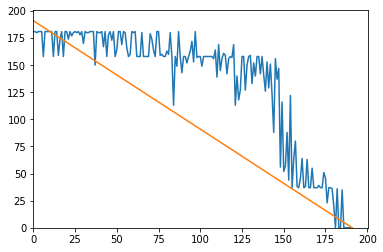

In [33]:
np_output = infer_output.numpy()
np_output = np_output.reshape(np_output.shape[0]).astype(np.int)
plt.plot(range(192), np_output[:192])
plt.plot(range(192), train.target[:192])
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

In [66]:
np_output[191]

10

In [67]:
np_output

array([163, 175, 175, ...,   0,   0,   0])